In [1]:
%load_ext autoreload
%autoreload 2

import bz2
import json

import pandas as pd

import texthero as hero

import texthero.preprocessing as hp

import imblearn

from helpers import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, LsiModel, TfidfModel, Word2Vec, FastText, Doc2Vec
import re
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /Users/mroust/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mroust/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Read file in chunks
# with pd.read_json(DATA_FOLDER + 'quotes-2020-party_labeled.json', lines=True, chunksize=10000) as df_reader:
# with pd.read_json(QUOTES_2020_PARTY_LABELED_SMALL_PATH, lines=True, compression='bz2', chunksize=100000) as df_reader:
#     for chunk in df_reader:
#         break


# df_quotes = chunk


In [4]:
df_quotes_party_labeled = pd.read_json(QUOTES_2020_PARTY_LABELED_SMALL_PATH, lines=True, compression='bz2')

In [5]:
df_quotes_party_labeled

,quoteID,quotation,speaker,date,numOccurrences,id,party_label
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,2020-01-16 12:00:13,1,Q367796,R
1,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,2020-01-26 13:21:36,11,Q771586,D
2,2020-01-26-040663,"The generational thing is important, quite hon...",Dave Loebsack,2020-01-26 13:21:36,11,Q771586,D
3,2020-01-20-000982,a host of other protections,Debbie Lesko,2020-01-20 15:32:48,1,Q16731415,R
4,2020-01-09-060095,"No, are you kidding? The way that this place l...",Debbie Lesko,2020-01-09 23:15:21,1,Q16731415,R
...,...,...,...,...,...,...,...
30523,2020-01-28-069262,She is ready to win and be an independent voic...,Cheri Bustos,2020-01-28 21:15:19,1,Q723148,D
30524,2020-04-15-075002,We're not used to a virus that we can't see.,Tom Corcoran,2020-04-15 00:00:00,1,Q7482898,R
30525,2020-02-12-019131,ensure my constituents have reliable access to...,Tammy Baldwin,2020-02-12 21:20:06,2,Q40628,D
30526,2020-01-11-021799,In terms of the actual investment and dollar s...,Scott Murphy,2020-01-11 08:00:00,1,Q290602,D


In [6]:
df = df_quotes_party_labeled

Text(0, 0.5, 'samples')

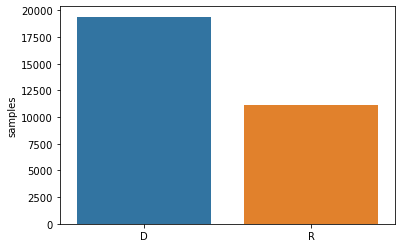

In [7]:
target_values = df['party_label'].value_counts()
sns.barplot(x=target_values.index, y=target_values)
plt.gca().set_ylabel('samples')

In [40]:
ros=imblearn.over_sampling.RandomOverSampler()
# ros=imblearn.under_sampling.RandomUnderSampler()
df_oversampled,_=ros.fit_resample(df, df['party_label'])
print(df_oversampled.shape)
df_oversampled.head()

(38820, 8)


,quoteID,quotation,speaker,date,numOccurrences,id,party_label,clean_quote
0,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,2020-01-26 13:21:36,11,Q771586,D,candidates better part world
1,2020-01-26-040663,"The generational thing is important, quite hon...",Dave Loebsack,2020-01-26 13:21:36,11,Q771586,D,generational thing important quite honestly th...
2,2020-01-08-006055,Any organization committed to operating respon...,Al Gore,2020-01-08 10:20:00,2,Q19673,D,organization committed operating responsibly n...
3,2020-01-23-080392,The burden to act on the shoulders of the gene...,Al Gore,2020-01-23 14:59:10,2,Q19673,D,burden act shoulders generation people alive t...
4,2020-01-11-001768,"All I knew was that if Al Gore was for it, I w...",Al Gore,2020-01-11 17:48:49,1,Q19673,D,knew al gore


Text(0, 0.5, 'samples')

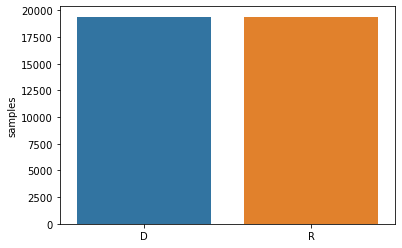

In [41]:
target_values = df_oversampled['party_label'].value_counts()
sns.barplot(x=target_values.index, y=target_values)
plt.gca().set_ylabel('samples')

In [42]:
df=df_oversampled

In [43]:
def clean(df):
    df = hp.fillna(df)
    df = hp.lowercase(df)
    df = hp.remove_digits(df)
    df = hp.remove_punctuation(df)
    df = hp.remove_diacritics(df)
    df = hp.remove_stopwords(df)
    df = hp.remove_whitespace(df)

    # df = df.apply(lambda x: x.split(" "))

    return df

In [44]:
df['clean_quote'] = clean(df['quotation'])
df.head()


,quoteID,quotation,speaker,date,numOccurrences,id,party_label,clean_quote
0,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,2020-01-26 13:21:36,11,Q771586,D,candidates better part world
1,2020-01-26-040663,"The generational thing is important, quite hon...",Dave Loebsack,2020-01-26 13:21:36,11,Q771586,D,generational thing important quite honestly th...
2,2020-01-08-006055,Any organization committed to operating respon...,Al Gore,2020-01-08 10:20:00,2,Q19673,D,organization committed operating responsibly n...
3,2020-01-23-080392,The burden to act on the shoulders of the gene...,Al Gore,2020-01-23 14:59:10,2,Q19673,D,burden act shoulders generation people alive t...
4,2020-01-11-001768,"All I knew was that if Al Gore was for it, I w...",Al Gore,2020-01-11 17:48:49,1,Q19673,D,knew al gore


In [45]:
temp=df[['party_label','clean_quote']]
temp

,party_label,clean_quote
0,D,candidates better part world
1,D,generational thing important quite honestly th...
2,D,organization committed operating responsibly n...
3,D,burden act shoulders generation people alive t...
4,D,knew al gore
...,...,...
38815,R,important tests available people need health c...
38816,R,decline comment pending litigation
38817,R,first question senate actually resolve phone c...
38818,R,say one things healthy family great time go go...


In [46]:
words_split = temp.copy()
words_split['clean_quote']=temp['clean_quote'].map(lambda x: x.split(" "))
words_split

,party_label,clean_quote
0,D,"[candidates, better, part, world]"
1,D,"[generational, thing, important, quite, honest..."
2,D,"[organization, committed, operating, responsib..."
3,D,"[burden, act, shoulders, generation, people, a..."
4,D,"[knew, al, gore]"
...,...,...
38815,R,"[important, tests, available, people, need, he..."
38816,R,"[decline, comment, pending, litigation]"
38817,R,"[first, question, senate, actually, resolve, p..."
38818,R,"[say, one, things, healthy, family, great, tim..."


In [47]:
words=words_split.explode(column='clean_quote')
words.rename(columns={'clean_quote':'word'},inplace=True)
words

,party_label,word
0,D,candidates
0,D,better
0,D,part
0,D,world
1,D,generational
...,...,...
38818,R,business
38818,R,going
38819,R,different
38819,R,kind


In [48]:
common_words=words['word'].value_counts().head(20)
common_words

people       4582
president    4196
going        3298
think        3002
would        2442
trump        2326
get          2232
need         2150
one          2019
know         1999
american     1865
us           1836
want         1772
time         1763
make         1724
like         1695
country      1651
health       1613
right        1455
state        1345
Name: word, dtype: int64

In [49]:
common_words_list = common_words.index.to_list()
only_common_words = words[words['word'].map(lambda x: x in common_words_list)]
only_common_words

,party_label,word
1,D,think
3,D,people
5,D,right
5,D,going
8,D,president
...,...,...
38818,R,one
38818,R,time
38818,R,people
38818,R,country


In [50]:
only_common_words.value_counts()

party_label  word     
D            people       2425
R            president    2194
             people       2157
D            president    2002
R            going        1713
             think        1655
D            going        1585
             trump        1370
R            would        1359
D            think        1347
R            get          1161
D            need         1084
             would        1083
             get          1071
             know         1069
R            need         1066
             american     1038
             one          1021
D            one           998
             us            968
R            trump         956
D            country       955
R            time          947
             want          934
             know          930
             us            868
D            make          863
R            make          861
             like          857
D            health        843
             want          838
             lik

<AxesSubplot:xlabel='count', ylabel='word'>

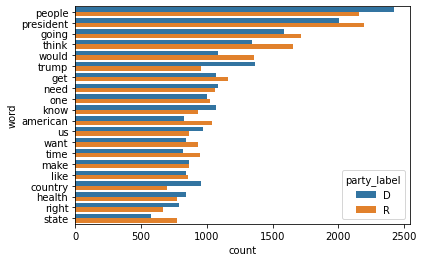

In [39]:
sns.countplot(data=only_common_words, y='word', hue='party_label', order=only_common_words['word'].value_counts().index)

In [55]:
dems = df[df['party_label'] == 'D']
reps = df[df['party_label'] == 'R']

In [159]:
dems_counts = hero.visualization.top_words(dems['cleaned_quote'])
dems_counts = dems_counts.reset_index()
dems_counts['party_label'] = 'D'

dems_counts['cleaned_quote'] = dems_counts['cleaned_quote']/2425

dems_counts

,index,cleaned_quote,party_label
0,people,1.000000,D
1,president,0.825567,D
2,going,0.653608,D
3,trump,0.564948,D
4,think,0.555464,D
...,...,...,...
15244,tommorrow,0.000412,D
15245,sketching,0.000412,D
15246,reflecting,0.000412,D
15247,restricted,0.000412,D


In [160]:
reps_counts = hero.visualization.top_words(reps['cleaned_quote'])

reps_counts = reps_counts.reset_index()
reps_counts['party_label'] = 'R'

reps_counts['cleaned_quote'] = reps_counts['cleaned_quote']/1268

reps_counts


,index,cleaned_quote,party_label
0,president,1.000000,R
1,people,0.986593,R
2,going,0.761830,R
3,think,0.720820,R
4,would,0.626972,R
...,...,...,...
12656,pda,0.000789,R
12657,deployments,0.000789,R
12658,bastards,0.000789,R
12659,buckeyes,0.000789,R


In [166]:
top_words = pd.concat((reps_counts.reset_index(), (dems_counts.reset_index()))).drop('level_0',axis=1)
display(top_words.sort_values(by = 'cleaned_quote',ascending=False))


,index,cleaned_quote,party_label
0,president,1.000000,R
0,people,1.000000,D
1,people,0.986593,R
1,president,0.825567,D
2,going,0.761830,R
...,...,...,...
11339,h1n1,0.000412,D
11338,badge,0.000412,D
11337,endured,0.000412,D
11336,discounts,0.000412,D


In [162]:
top_rep = list(top_words[top_words['party_label'] == 'R'].sort_values(by = 'cleaned_quote', ascending = False).head(20)['index'])
top_dem = list(top_words[top_words['party_label'] == 'D'].sort_values(by = 'cleaned_quote', ascending = False).head(20)['index'])

top_words_rep = top_words[top_words['index'].isin(top_rep) ]
top_words_dem = top_words[top_words['index'].isin(top_dem) ]

In [163]:
top_words_rep

,index,cleaned_quote,party_label
0,president,1.000000,R
1,people,0.986593,R
2,going,0.761830,R
3,think,0.720820,R
4,would,0.626972,R
5,get,0.507886,R
6,need,0.492114,R
7,american,0.469243,R
8,one,0.452681,R
9,trump,0.442429,R


In [150]:
top_words_dem

,index,cleaned_quote,party_label
0,president,1.000000,R
1,people,0.986593,R
2,going,0.761830,R
3,think,0.720820,R
4,would,0.626972,R
5,get,0.507886,R
6,need,0.492114,R
7,american,0.469243,R
8,one,0.452681,R
9,trump,0.442429,R


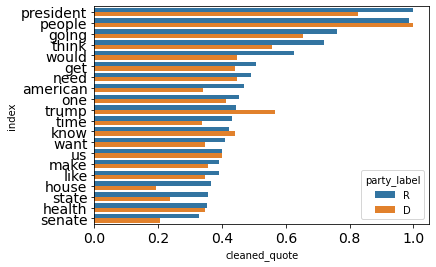

In [167]:
# sns.countplot(x='index', y='cleaned_quote', hue='party_label')

plot = sns.barplot(data=top_words_rep, y='index', x='cleaned_quote', hue='party_label', dodge=True)
# plot.tick_params(length=0)
plot.tick_params(labelsize=14)


<AxesSubplot:xlabel='cleaned_quote', ylabel='index'>

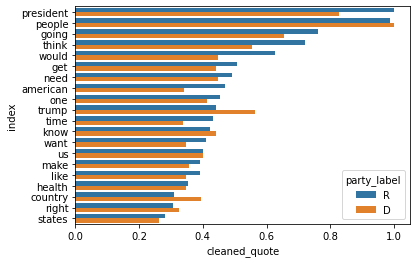

In [148]:
sns.barplot(data=top_words_dem, y='index', x='cleaned_quote', hue='party_label')